<a href="https://colab.research.google.com/github/twelvesense/first-repository/blob/master/ExplNode03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Node 3. 프로젝트 : Tesla 주식 예측에 도전해 보자

***주의사항: 아래 코드에서 import ARIMA 부분에서 error발생시, 모듈 statsmodels을 update해야함!***

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings
warnings.filterwarnings('ignore')

# ADF test
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Rolling Stats.
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

---
### 1. 시계열 데이터 준비

##### 1-1. Tesla의 2021년04월28부터 2022년 4월27일까지의 주가 정보 (종가기준)

In [21]:
path_file = 'https://raw.githubusercontent.com/twelvesense/first-repository/master/data/TSLA.csv'
df = pd.read_csv(path_file, index_col='Date', parse_dates=True)
ts = df['Close']
ts.shape

(253,)

In [22]:
ts.head()

Date
2021-04-28    694.400024
2021-04-29    677.000000
2021-04-30    709.440002
2021-05-03    684.900024
2021-05-04    673.599976
Name: Close, dtype: float64

---
### 2. 각종 전처리 수행
##### 2-1. 결측치 유무 확인

In [6]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

>>><u>**[ M E M O ] 혹시 모를 결측치를 위해, time기준으로 보간하고, 보간 후 결측치 유무 점검시, 없음을 확인할 수 있다.**</u>

##### 2-2. 로그 변환

In [7]:
ts_log = np.log(ts)

---
### 3. 시계열 안정성 분석
##### 3-1. 정성적 그래프 분석

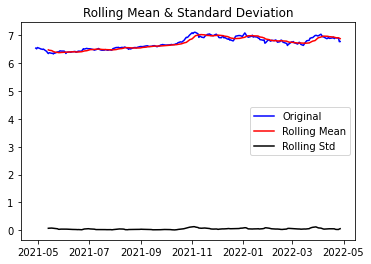

In [8]:
plot_rolling_statistics(ts_log, window=12)

>>><u>**[ M E M O ] 이동평균과 원데이터간의 차이를 시각적으로 확인할 수 있다.**</u>

##### 3-2. 정량적 Augmented Dicky-Fuller Test

In [9]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.417388
p-value                          0.573912
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


>>><u>**[ M E M O ] p-value가 0.57정도여서, 시계열 데이터의 안정성(stationary)이 보장된다고 보기 어렵다.**</u>

##### 3-3. 시계열 분해 (Time Series Decomposition)기법을 적용하기

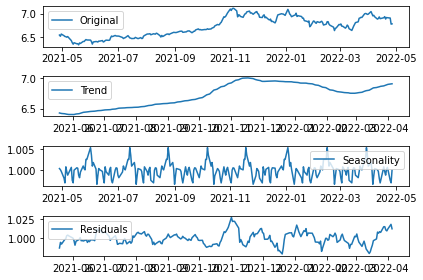

In [11]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

>>><u>**[ M E M O ] 바다 stationary한 시계열로 가공해가 위해서 Residuals를 구해 보았다.**</u>

##### 3-4. Residual 안정성 확인

In [12]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.366543e+00
p-value                        2.402093e-08
#Lags Used                     7.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


>>><u>**[ M E M O ] Decomposing을 통해서 Redidual이 낮은 p-value를 보임을 확인할 수 있다.**</u>

---
### 4. 학습, 테스트 데이터셋 생성
##### 4-1 학습, 테스트 데이터셋 분리하기 (9:1)

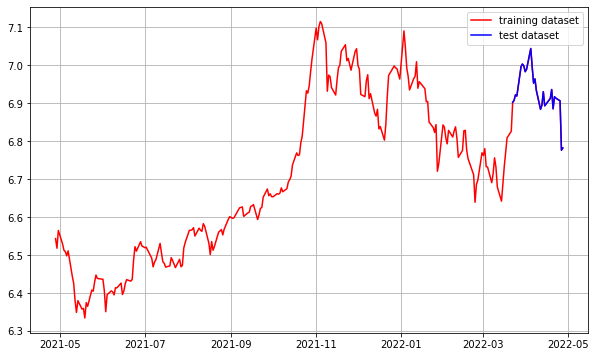

In [13]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

---
### 5. 적정 ARIMA 모수 찾기
##### 5-1. ACF, PACF 그려보고 p,q 값 구하기

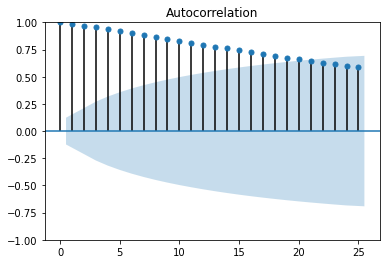

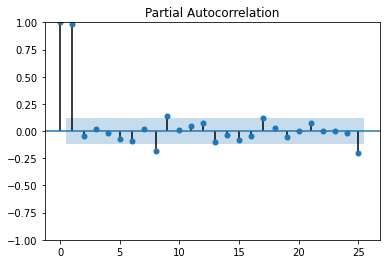

In [14]:
plot_acf(ts_log)   # ACF : Autocorrelation
plot_pacf(ts_log)  # PACF : Partial Autocorrelation
plt.show()

>>><u>**[ M E M O ] PACF가 sine파 모양으로 높은 시차에서도 0이 되지않아, p는 0, q는 일단 30으로 정해본다.**</u>

##### 5-2. 차분 안정성 확인하고, d 값 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.558187e+01
p-value                        1.928095e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


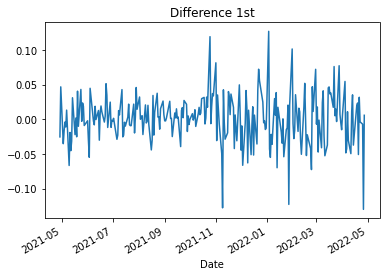

In [15]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

>>><u>**[ M E M O ] 1차 차분으로도 p-value가 충분히 작아 안정성이 있다고 판단되며, d = 0으로 정해본다.**</u>

---
### 6. ARIMA 모델 훈련과 테스트
##### 6-1. 1차 ARIMA 모델 빌드와 훈련 (0, 0, 30)

In [50]:
model = ARIMA(train_data, order=(0, 0, 30))  
fitted_m = model.fit() 
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                ARIMA(0, 0, 30)   Log Likelihood                 457.589
Date:                Thu, 05 May 2022   AIC                           -851.179
Time:                        14:27:25   BIC                           -741.580
Sample:                             0   HQIC                          -806.954
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6972      0.059    113.107      0.000       6.581       6.813
ma.L1          1.0785      0.078     13.793      0.000       0.925       1.232
ma.L2          1.1009      0.106     10.370      0.0

##### 6-1-1. 1차 모델 테스트

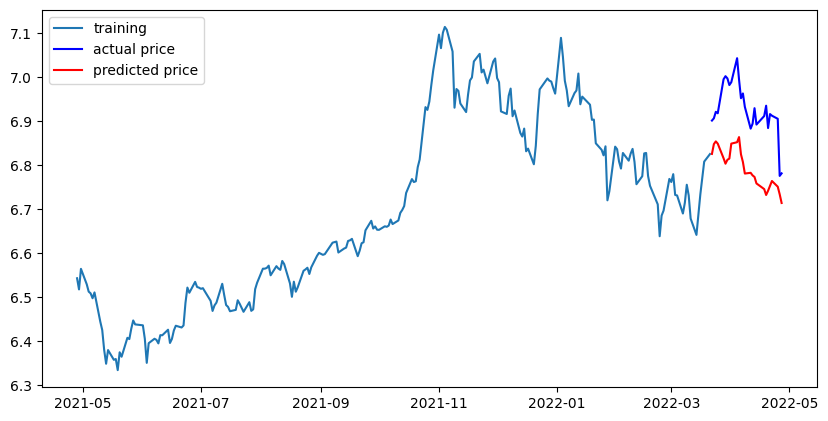

In [51]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

##### 6-1-2. 1차 예측 모델 정확도 측정(MAPE)

In [52]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18829.04315017797
MAE:  129.3173360735821
RMSE:  137.2189606074101
MAPE: 12.48%


##### 6-2. 2차 ARIMA 모델 빌드와 훈련 (0, 1, 30)

In [53]:
model = ARIMA(train_data, order=(0, 1, 30))  
fitted_m = model.fit() 
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                ARIMA(0, 1, 30)   Log Likelihood                 464.246
Date:                Thu, 05 May 2022   AIC                           -866.492
Time:                        14:31:40   BIC                           -760.455
Sample:                             0   HQIC                          -823.700
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0336      0.087      0.384      0.701      -0.138       0.205
ma.L2         -0.0057      0.072     -0.078      0.938      -0.148       0.136
ma.L3         -0.0014      0.092     -0.015      0.9

##### 6-2-1. 2차 모델 테스트

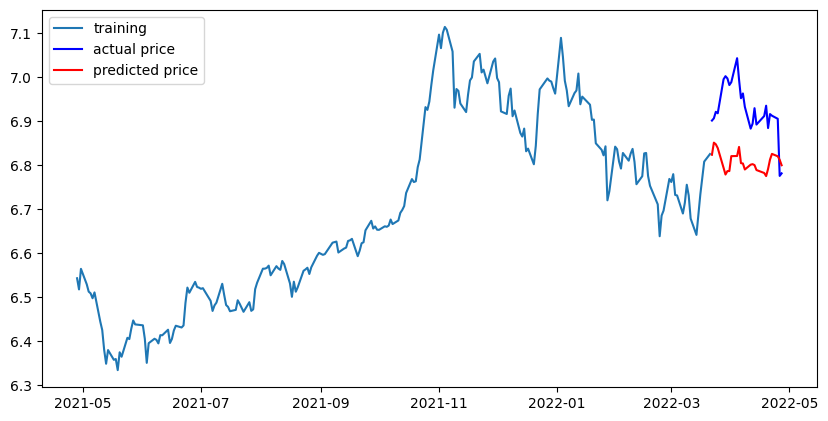

In [54]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

##### 6-2-2. 2차 예측 모델 정확도 측정(MAPE)

In [55]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  17847.195626293353
MAE:  120.83967825148548
RMSE:  133.5933966418002
MAPE: 11.55%


##### 6-3. 3차 ARIMA 모델 빌드와 훈련 (1, 1, 30)

In [56]:
model = ARIMA(train_data, order=(1, 1, 30))  
fitted_m = model.fit() 
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                ARIMA(1, 1, 30)   Log Likelihood                 463.154
Date:                Thu, 05 May 2022   AIC                           -862.308
Time:                        14:35:58   BIC                           -752.851
Sample:                             0   HQIC                          -818.135
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1936      0.905     -0.214      0.831      -1.968       1.581
ma.L1          0.2105      0.902      0.233      0.815      -1.557       1.977
ma.L2         -0.0099      0.072     -0.138      0.8

##### 6-3-1. 3차 모델 테스트

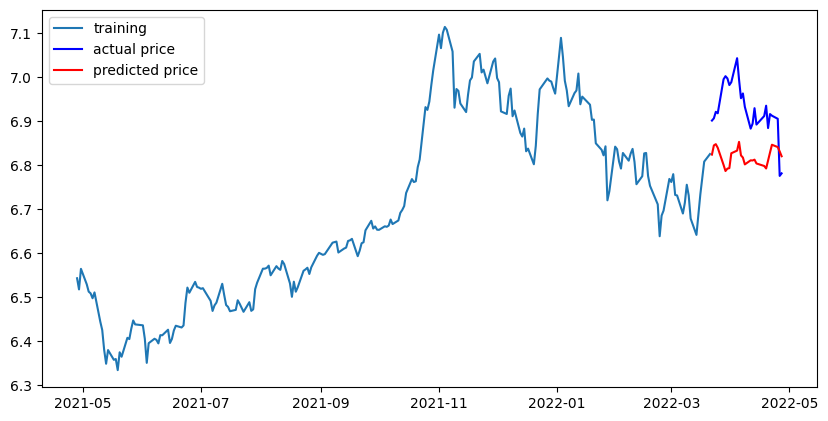

In [57]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

##### 6-3-2. 3차 예측 모델 정확도 측정(MAPE)

In [58]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  15767.055395952086
MAE:  113.49477648053723
RMSE:  125.56693591846576
MAPE: 10.86%


##### 6-4. 4차 ARIMA 모델 빌드와 훈련 (1, 2, 40)

In [72]:
model = ARIMA(train_data, order=(1, 3, 40))  
fitted_m = model.fit() 
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                ARIMA(1, 3, 40)   Log Likelihood                 435.906
Date:                Thu, 05 May 2022   AIC                           -787.811
Time:                        14:46:54   BIC                           -644.522
Sample:                             0   HQIC                          -729.973
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7515      0.308     -2.443      0.015      -1.354      -0.149
ma.L1         -1.0278      0.674     -1.525      0.127      -2.348       0.293
ma.L2         -0.6388      1.256     -0.509      0.6

##### 6-4-1. 4차 모델 테스트

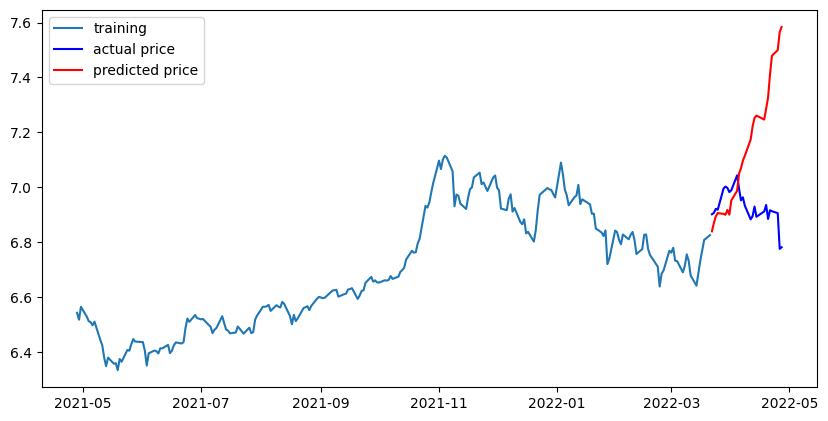

In [73]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

##### 6-4-2. 4차 예측 모델 정확도 측정(MAPE)

In [74]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  204608.45855924874
MAE:  324.3212656941645
RMSE:  452.3366650618196
MAPE: 33.32%


---
### 7. 예측 평가

>>><u>**[ M E M O ] 이번 Tesla주가는 stationary하지 않았고 그렇게 만들기도 쉽지 않았다.**</u>

>>><u>**다만, AR보다 MA경향이 컸으며, 시행착오를 통해서 I값과 MA값을 증가함에 따라 예측이 잘 됨을 확인할 수 있었다.**</u>